# Quick Analysis: Ho Chi Minh City

This notebook constitutes a quick analysis of settlement dynamics in Ho Chi Minh City under our spatially-driven settlement model. As a reminder, 

In [1]:
# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Import Packages, Read Data

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from urban_growth.estimator import *
from urban_growth.components import *
from itertools import product
import pandas as pd
import pickle
from scipy.special import expit
from matplotlib.colors import LogNorm

%matplotlib inline

In [3]:
years      = [1990, 2000, 2010, 2015]
throughput_dir = 'throughput/HCM'

plot_args = {'interpolation' : 'nearest', 'cmap' : 'Greys'}

In [4]:
def f(x, delim):
    path = throughput_dir + '/HCM_' + str(x) + '.txt'
    return np.loadtxt(path, dtype=int, delimiter=delim)

maps  = {year : f(year, ' ') for year in years}
geo = np.loadtxt(throughput_dir + '/HCM_geo.txt')

In [5]:
file_Name = "throughput/HCM_estimates"
fileObject = open(file_Name,'r')  
df = pickle.load(fileObject)
df = df.reset_index()

In [14]:
maxes = df.groupby('Y0').ll.transform(max)
maxes = df[df.ll == maxes] 
maxes = maxes.reset_index()

pars = np.concatenate([par[np.newaxis,] for par in maxes.pars_hat], axis = 0)

sigs = [np.diag(np.sqrt(maxes.h_inv[i] / maxes.N[i])) for i in range(3)]

sigs = 2 * np.concatenate([sig[np.newaxis,] for sig in sigs], axis = 0)


/home/pchodrow/city-simulator/venv/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


# Parameters and Elementary Diagnostics

The first and simplest thing we'd like to do is visualize the learned parameters, their uncertainty intervals, and diagnose the model fit. The latter piece especially requires further work, but we can get some elementary views of how we're doing below. 

- In **(A)**, we show the rate coefficients $\alpha$. 
- In **(B)**, we show the spatial dispersion exponents $\gamma$. 
- In **(C)**, we show the settlement rate $p$ as compared to the background rate $\sigma(\beta)$. If these numbers were comparable, then we would essentially by relying on the background rate for the entirety of our prediction, indicating that the spatial model has no value. However, we see that the background rate accounts for roughly 1/3 to 1/5th of the total prediction settlement, indicating that the majority of settlement may be modeled through local processes in our framework. 
- In **(D)**, we show the model log-likelihood $\log \mathcal{L}$. This much higher than the binary entropy $H(p)$ of the settlement rate, which is additional confirmation that we are capturing spatial structure in the data. A future analysis we should perform is to compare this to the expected log-likelihood under the true model. 

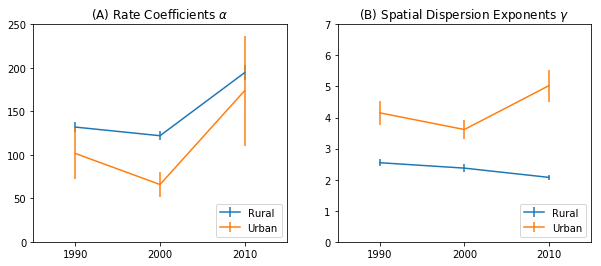

In [15]:
f, axs = plt.subplots(1, 2, figsize = (10, 4))

ax = axs[0]
ax.errorbar(maxes.Y0, pars[:,0], yerr = sigs[:,0], label = 'Rural')
ax.errorbar(maxes.Y0, pars[:,1], yerr = sigs[:,1], label = 'Urban')
ax.set(xlim = (1985, 2015), ylim = (0, 250))
ax.legend(loc = 4)
ax.set_title(r'(A) Rate Coefficients $\alpha$')
ax.xaxis.set_ticks(maxes.Y0)

ax = axs[1]
ax.errorbar(maxes.Y0, pars[:,2], yerr = sigs[:,2], label = 'Rural')
ax.errorbar(maxes.Y0, pars[:,3], yerr = sigs[:,3], label = 'Urban')
ax.set(xlim = (1985, 2015), ylim = (0, 7))
ax.legend(loc = 4)
ax.set_title(r'(B) Spatial Dispersion Exponents $\gamma$')
ticks = ax.xaxis.set_ticks(maxes.Y0)
plt.savefig('figs/alpha_gamma.pdf')

# Learned Densities

We now consider the model settlement probabilities under the learned parameters, which we visualize below alongside the data itself. 

In [32]:
densities = {}
for i in range(len(maxes)):
    e = estimator(M0 = maps[years[i]], geo = geo, model = 'logistic', unit = 2.5)
    e.update_morphology()
    e.make_dist_array()
    e.partition_clusters([maxes['T'][i]])
    e.partition_dist_array()

    pars_internal = {
        'alpha' : maxes.pars_hat[i][0:2],
        'gamma' : maxes.pars_hat[i][2:4],
        'beta'  : maxes.pars_hat[i][4],
    }

    d = logistic_density(e, **pars_internal)
    d[maps[years[i]] == 1] = np.nan
    d[geo == 0] = np.nan
    densities.update({i : d})  

/home/pchodrow/city-simulator/venv/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


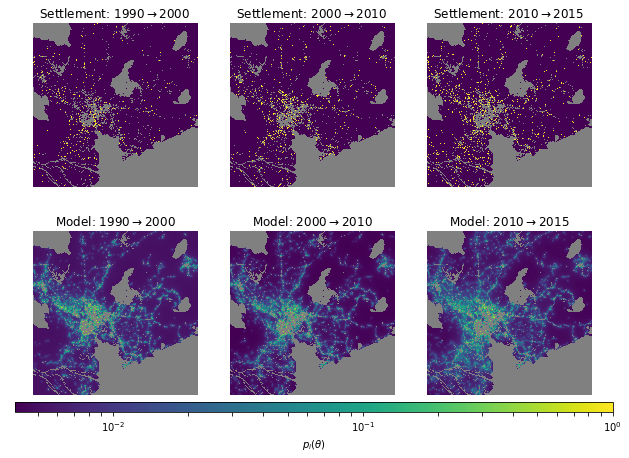

In [56]:
import copy

f, axs = plt.subplots(2, 3, figsize = (10, 7))

vmin = np.nanmin(np.concatenate([d for d in densities.values()]))
vmax = np.nanmax(np.concatenate([d for d in densities.values()]))

for i in range(len(maxes)):
    X = maps[years[i+1]] - maps[years[i]]
    X = X.astype('float64')
    X[geo == 0] = np.nan
    X[X < 0] = 0
    X[maps[years[i]] == 1] = np.nan
    
    ma_X = np.ma.array(X, mask=np.isnan(X))
    cmap=copy.copy(cm.viridis)
    cmap.set_bad('grey',1.)
    
    im = axs[0][i].imshow(X, interpolation = 'nearest', cmap  = cmap)
    
    axs[0][i].set_title('Settlement: ' + str(years[i]) + r'$\rightarrow$' + str(years[i+1])) 
    axs[0][i].axis('off')
    
    ma_D = np.ma.array(densities[i], mask = np.isnan(densities[i]))
    
    im = axs[1][i].imshow(ma_D, 
                          interpolation = 'nearest', 
                          cmap = cmap,
                          norm=LogNorm(vmin=vmin, vmax=1))
    axs[1][i].set_title('Model: ' + str(years[i]) + r'$\rightarrow$' + str(years[i+1])) 
    axs[1][i].axis('off')

cax = f.add_axes([0.1, 0.1, 0.83, 0.02])
cbar = f.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$p_i(\theta)$')
plt.savefig('figs/maps.pdf')

In [81]:
M = linear_components(e, df.pars_hat[2][0:2], df.pars_hat[2][2:4])
M.sum(axis = (1, 2))

array([ 60759.67993275,  23658.14653561])

/home/pchodrow/city-simulator/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


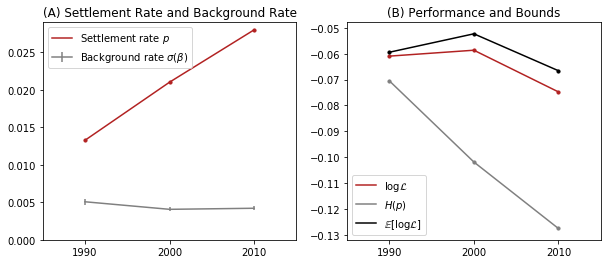

In [69]:
pars = np.concatenate([par[np.newaxis,] for par in maxes.pars_hat], axis = 0)
sigs = [np.diag(np.sqrt(df.h_inv[i] / df.N[i])) for i in range(len(maxes))]
sigs = 2 * np.concatenate([sig[np.newaxis,] for sig in sigs], axis = 0)


f, axs = plt.subplots(1, 2, figsize = (10, 4))
ax = axs[0]
ax.errorbar(maxes.Y0, 
                expit(pars[:,4]), 
                yerr = expit(pars[:,4]) * expit(1 - pars[:,4]) * sigs[:,4],
                label = r'Background rate $\sigma(\beta)$',
                color = 'grey')

def prop(i):
    X = maps[years[i+1]] - maps[years[i]]
    X[X < 0] = 0
    X = X.astype('float')
    X[maps[years[i]] == 1] = np.nan
    X[geo == 0] = np.nan

    return np.nanmean(X)
props = [prop(i) for i in range(3)]

ax.plot(maxes.Y0, 
        props, 
        label = r'Settlement rate $p$',
        color = 'firebrick')
ax.scatter(maxes.Y0, 
        props, 
        label = '_nolegend_',
        color = 'firebrick', s = 10)

ax.set(xlim = (1985, 2015))
ax.legend(loc = 2)
ax.set_title(r'(A) Settlement Rate and Background Rate')
ax.xaxis.set_ticks(maxes.Y0)
ax.set(ylim = (0, max(props) + .001))

ax = axs[1]
H = [props[i] * np.log(props[i]) + (1 - props[i]) * np.log(1 - props[i]) for i in range(3)]

def E_ll(i):
    d = densities[i]
    return np.nanmean(d * np.log(d) + (1 - d) * (np.log(1 - d)))

ell = [E_ll(i) for i in range(3)]

ax.plot(maxes.Y0, 
        maxes.ll, 
        label = r'$\log \mathcal{L}$', 
        color = 'firebrick')

ax.scatter(maxes.Y0, 
        maxes.ll, 
        label = '_nolegend_', 
        color = 'firebrick', s = 10)

ax.plot(maxes.Y0, 
        H, 
        label = r'$H(p)$', 
        color = 'grey')

ax.scatter(maxes.Y0, 
            H, 
            label = '_nolegend_', 
            color = 'grey', s = 10)

ax.plot(maxes.Y0, 
        ell,  
        label = r'$\mathbb{E}[\log \mathcal{L}]$', 
        color = 'black')

ax.scatter(maxes.Y0, 
        ell, 
            label = '_nolegend_', 
        color = 'black', 
          s = 10)

ax.set_title('(B) Performance and Bounds')
ax.legend(loc = 3)
t = ax.xaxis.set_ticks(maxes.Y0)
xl = ax.set(xlim = (1985, 2015))
plt.savefig('figs/performance.pdf')

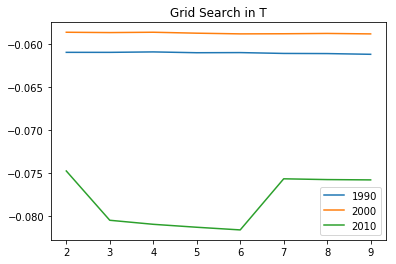

In [46]:
for Y in sorted(set(df.Y0)):
    plt.plot(df['T'][df.Y0 == Y], df['ll'][df.Y0 == Y], label = Y)
    plt.legend()
    plt.title('Grid Search in T')
    
plt.savefig('figs/T_search.pdf')

/home/pchodrow/city-simulator/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


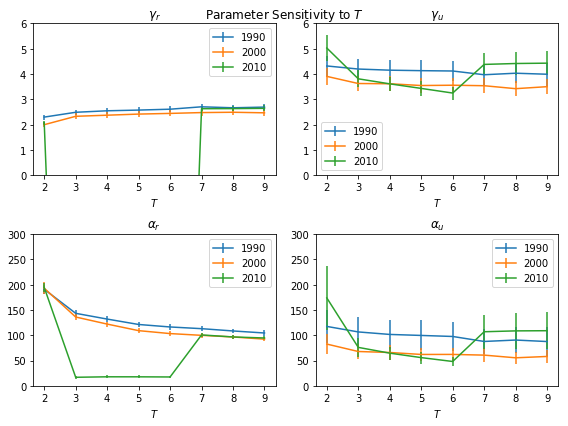

In [47]:
pars = np.concatenate([par[np.newaxis,] for par in df.pars_hat], axis = 0)
sigs = [np.diag(np.sqrt(df.h_inv[i] / df.N[i])) for i in range(len(df))]
sigs = 2 * np.concatenate([sig[np.newaxis,] for sig in sigs], axis = 0)

f, axs = plt.subplots(2, 2, figsize = (8, 6))

for Y in sorted(set(df.Y0)):
    Y_vec = df.Y0 == Y
    axs[0][0].errorbar(df['T'][Y_vec], 
                       pars[Y_vec, 2], 
                       yerr = sigs[Y_vec, 2], 
                       label = Y)
    axs[0][0].legend()
    axs[0][0].set(ylim = (0, 6))    
    axs[0][0].set_title(r'$\gamma_r$')
    axs[0][0].set_xlabel(r'$T$')
    
    axs[0][1].errorbar(df['T'][Y_vec], 
                       pars[Y_vec, 3],
                       yerr = sigs[Y_vec, 3], 
                       label = Y)
    axs[0][1].legend()
    axs[0][1].set(ylim = (0, 6))
    axs[0][1].set_title(r'$\gamma_u$')
    axs[0][1].set_xlabel(r'$T$')
    
    axs[1][0].errorbar(df['T'][Y_vec], 
                   pars[Y_vec, 0], 
                   yerr = sigs[Y_vec, 0],
                   label = Y)
    axs[1][0].legend()
    axs[1][0].set(ylim = (0, 300))
    axs[1][0].set_xlabel(r'$T$')

    axs[1][0].set_title(r'$\alpha_r$')
    
    axs[1][1].errorbar(df['T'][Y_vec], 
                   pars[Y_vec, 1], 
                   yerr = sigs[Y_vec, 1],
                   label = Y)
    axs[1][1].legend()
    axs[1][1].set(ylim = (0, 300))
    axs[1][1].set_xlabel(r'$T$')
    axs[1][1].set_title(r'$\alpha_u$')
    
plt.suptitle(r'Parameter Sensitivity to $T$')
plt.tight_layout()

plt.savefig('figs/T_sensitivity.pdf')